## Dacy

We could use Dacy to exclusively get the embeddings for each document. The idea being that Dacy might produce richer embeddings for Danish specifically. This requires running Dacy on each sample which would take ages.

Instead, we can use Dacy's **Sentiment Analysis** extension and compare it to the observed sentiment derived from the rating. This allows us to evaluate whether the pretrained sentiment analysis model is accurate for our data, and we can do so with a fraction of the full dataset.

In [1]:
import dacy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, log_loss)

In [2]:
# nlp = dacy.load('medium', exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])
nlp = dacy.load('medium')

c:\Python39\lib\site-packages\spacy\util.py:887: UserWarning: [W095] Model 'da_dacy_medium_trf' (0.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.5.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
c:\Python39\lib\site-packages\spacy_transformers\pipeline_component.py:402: UserWarning: Automatically converting a transformer component from spacy-transformers v1.0 to v1.1+. If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spacy-transformers version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
nlp.add_pipe('dacy/polarity')

In [4]:
df = pd.read_csv('Data/trustpilot.csv')

In [5]:
df_dacy = df.sample(200, random_state=42)
X = df_dacy['body']
y_test = df_dacy['sentiment']

In [6]:
dacy_docs = list(nlp.pipe(X))

c:\Python39\lib\site-packages\spacy\pipeline\attributeruler.py:150: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


In [7]:
y_pred = []
probs = []
for doc in dacy_docs:
    y_pred.append(doc._.polarity)
    # probabilities are dict with 'prob': [...] and 'labels': ['positive', 'neutral', 'negative']
    probs.append(doc._.polarity_prob['prob'])

In [8]:
# several ways of merging this data into the dataframe
prob_pos, prob_neu, prob_neg = zip(*probs)
df_dacy = df_dacy.assign(predicted=y_pred, prob_pos=prob_pos, prob_neu=prob_neu, prob_neg=prob_neg)

In [24]:
df_dacy.to_csv('Data/dacy_sentiment.csv', index=False)

[]

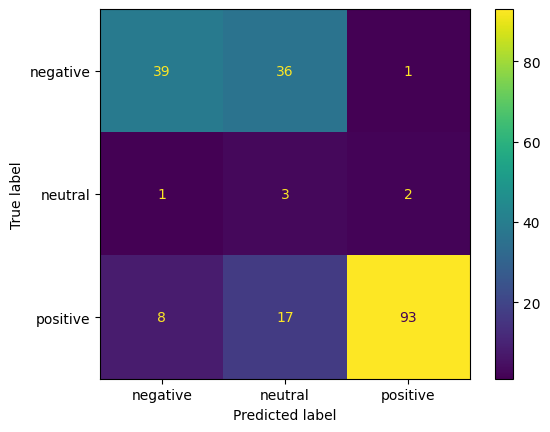

In [9]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.plot()

It misclassifies a lot of negatives as neutrals. Maybe if we look at what the prediction probabilities were, we can find a good threshold for when something is negative or not.

There's also some bias in that we have very few neutral cases to begin with. Only ratings of 3 are considered neutral, but using neutral language in a negative review is quote common. It can also be explained by ratings of 2 stars leaning more neutral than being truly negative.

Other than that, it seems pretty good.

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.81      0.51      0.63        76
     neutral       0.05      0.50      0.10         6
    positive       0.97      0.79      0.87       118

    accuracy                           0.68       200
   macro avg       0.61      0.60      0.53       200
weighted avg       0.88      0.68      0.75       200



`log_loss` should factor in the prediction probabilities when calculating performance. We want low loss values.

In [11]:
# Need to sort out prob values from the dicts and order them alphabetially by corresponding label
log_loss(y_test, df_dacy[['prob_neg', 'prob_neu', 'prob_pos']])

1.3282626944196405

Currently, we have no context for what this number means, but we can compare it with other models to see which performs better.

In [34]:
df_dacy.groupby('rating').median(numeric_only=True)

,prob_pos,prob_neu,prob_neg
rating,,,
1,0.0060,0.127,0.5980
2,0.0080,0.713,0.2770
3,0.0125,0.658,0.0105
4,0.9890,0.010,0.0020
5,0.9730,0.017,0.0020


Ratings of 1 and especially 2 have a disproportionate amount of neutral words. Neutral and positive have practically 0 negative sentiment.

We could set the threshold for what counts as negative as low as 0.15 potentially.

In [29]:
df_dacy[df_dacy['sentiment'] != df_dacy['predicted']].groupby('rating').median(numeric_only=True)

,prob_pos,prob_neu,prob_neg
rating,,,
1,0.007,0.9360,0.0140
2,0.007,0.9620,0.0305
3,0.641,0.0060,0.0070
4,0.002,0.9920,0.0060
5,0.017,0.8385,0.0040


Almost everything that was misclassified had extremely high neutral sentiment.

In [20]:
def plot_probabilities(df: pd.DataFrame):
    grouped = df.groupby('rating').mean(numeric_only=True)
    # grouped = grouped.rolling(3, center=True).mean()
    plt.plot(grouped['prob_neg'], label='Negative')
    plt.plot(grouped['prob_neu'], label='Neutral')
    plt.plot(grouped['prob_pos'], label='Positive')
    plt.xlabel('Rating')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

In [21]:
def plot_probabilities_smooth(df: pd.DataFrame):
    grouped = df.groupby('rating').mean(numeric_only=True)

    # create the x and y values for the spline interpolation
    x = grouped.index
    y_neg = grouped['prob_neg']
    y_neu = grouped['prob_neu']
    y_pos = grouped['prob_pos']

    # define the range of x values for the smoothed curve
    x_smooth = np.linspace(x.min(), x.max(), 100)

    # perform spline interpolation for each sentiment
    f_neg = interp1d(x, y_neg, kind='cubic')
    f_pos = interp1d(x, y_pos, kind='cubic')
    f_neu = interp1d(x, y_neu, kind='cubic')

    # create the smoothed line bands for each sentiment
    plt.plot(x_smooth, f_neg(x_smooth), label='Negative')
    plt.plot(x_smooth, f_neu(x_smooth), label='Neutral')
    plt.plot(x_smooth, f_pos(x_smooth), label='Positive')

    # add axis labels and legend
    plt.xlabel('Rating')
    plt.ylabel('Probability')
    plt.legend()

    # show the plot
    plt.show()

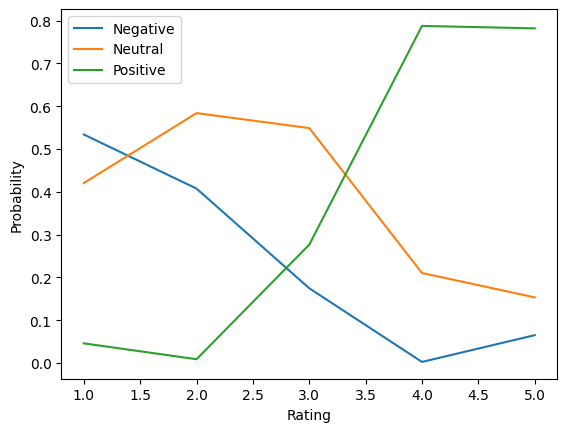

In [22]:
plot_probabilities(df_dacy)

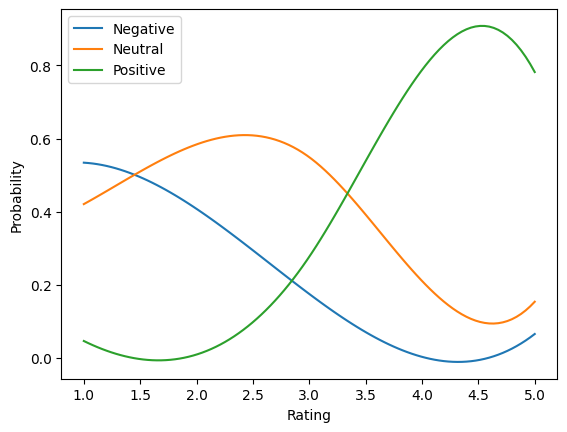

In [23]:
plot_probabilities_smooth(df_dacy)

## Adjust model
It may be possible to fine-tune the model to better fit our data, but I don't know how to do that.

It is easier to just use the existing model, but add a function to correct the prediction according to certain thresholds.

In [64]:
def correct_sentiment(row):
    if row['predicted'] == 'neutral' and row['prob_pos'] < 0.15 <= row['prob_neg']:
        return 'negative'

In [65]:
df_dacy['corrected'] = df_dacy.apply(correct_sentiment, axis=1)

In [80]:
wrong_predictions = df_dacy['sentiment'] != df_dacy['predicted']
corrections = df_dacy['corrected'].notna()
wrong_corrections = df_dacy['sentiment'] != df_dacy['corrected']

print('Corrections:', df_dacy[corrections].shape[0])
print('Still wrong:', df_dacy[wrong_predictions & ~corrections].shape[0])

Corrections: 11
Still wrong: 54


In [84]:
df_dacy[wrong_corrections & corrections]

,title,body,rating,sentiment,predicted,prob_pos,prob_neu,prob_neg,corrected
495,Fint forløb,Ingen problemet,5,positive,neutral,0.005,0.656,0.34,negative


In [79]:
df_dacy[wrong_predictions & ~corrections].value_counts('rating')

rating
1    24
5    23
2     3
3     3
4     1
dtype: int64

In [78]:
df_dacy[wrong_predictions & ~corrections].groupby('rating').median(numeric_only=True)

,prob_pos,prob_neu,prob_neg
rating,,,
1,0.0055,0.9865,0.0035
2,0.0050,0.9830,0.0080
3,0.6410,0.0060,0.0070
4,0.0020,0.9920,0.0060
5,0.0180,0.8430,0.0040


There's still a lot that weren't corrected, and they have extremely high neutral and almost nothing positive or negative for us to grab unto.

[]

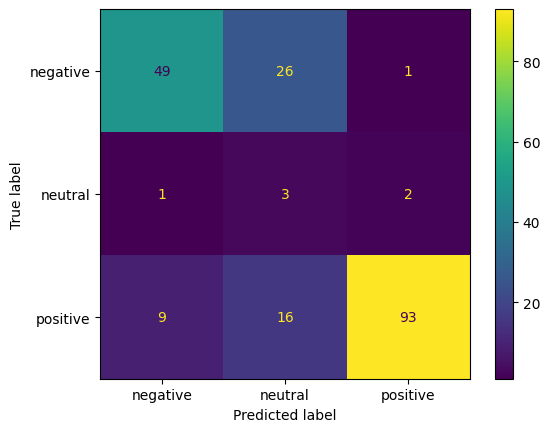

In [82]:
# confusion matrix for the corrected predictions
new_y_pred = df_dacy['corrected'].fillna(df_dacy['predicted'])
ConfusionMatrixDisplay.from_predictions(y_test, new_y_pred)
plt.plot()

It might not be good enough still.